<a href="https://colab.research.google.com/github/hane94/Machine-Learning-Practice/blob/master/lesson3_head_pose(hyeseon).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

## Getting and converting the data

In [8]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [9]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [0]:
fname = '09/frame_00667_rgb.jpg' #image file name

In [0]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

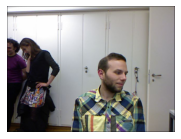

In [12]:
img = open_image(path/fname)
img.show()

In [13]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

point : XY coordinates / not pixels

In [15]:
get_ctr(fname) #coordinates of center of the face (263,428)

tensor([263.9104, 428.5814])

본 모델은 classification model이 아님, regression model

아웃풋이 continuous number혹은 set of number일때

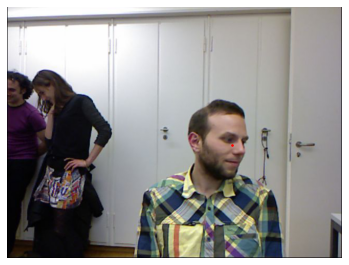

In [16]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating a dataset

In [0]:
data = (PointsItemList.from_folder(path) #ImageFileList
        .split_by_valid_func(lambda o: o.parent.name=='13') #validation폴더를 따로 지정해 준 것, 특정 사람
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

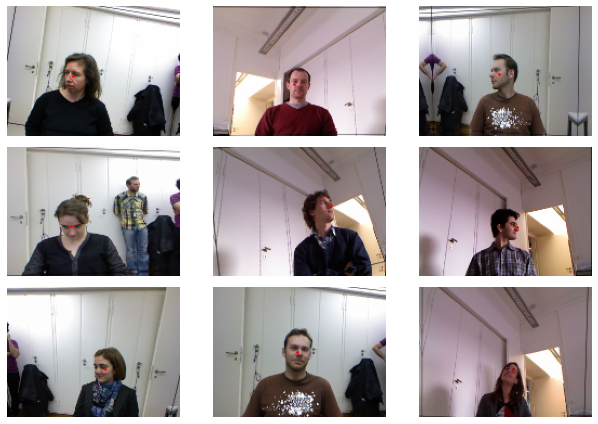

In [18]:
data.show_batch(3, figsize=(9,6))

## Train model

In [19]:
learn = cnn_learner(data, models.resnet34) #create cnn : convolutional neural network

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


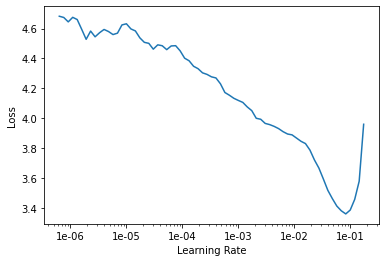

In [20]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 2e-2

In [22]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.127506,0.028819,02:53
1,0.043817,0.003902,02:54
2,0.014895,0.002402,02:55
3,0.008603,0.001766,02:56
4,0.006682,0.001800,02:56


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

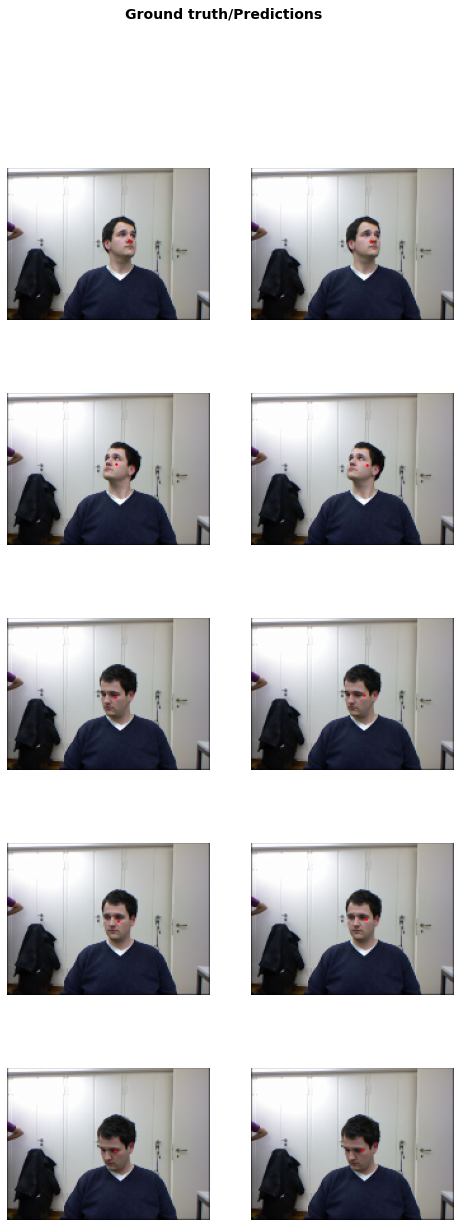

In [25]:
learn.show_results()

## Data augmentation

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

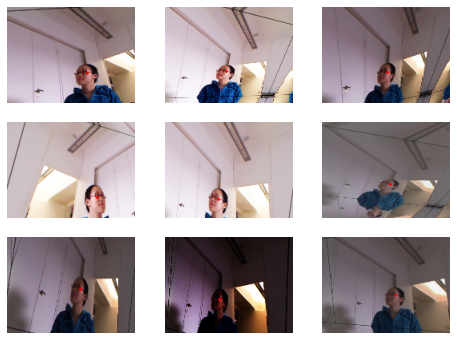

In [27]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))